In [13]:
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import matplotlib.pyplot as plt
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
import gym
import numpy as np
import time
from stable_baselines3.common.callbacks import EvalCallback
import env_test1
env = env_test1.DroneEnv()
check_env(env)
env = DummyVecEnv([lambda: env])

### 训练模型

In [5]:

#vec_env = VecNormalize(env, norm_obs=True, norm_reward=True,clip_obs=1)

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./tensorboard/",device="cuda")
# Evaluation callback
callbacks = []
eval_callback = EvalCallback(
    env,
    callback_on_new_best=None,
    n_eval_episodes=8,
    best_model_save_path=".",
    log_path=".",
    eval_freq=4000,
)

callbacks.append(eval_callback)
kwargs = {}
kwargs["callback"] = callbacks

log_name = "ppo_run_" + str(time.time())

model.learn(
    total_timesteps=100000,
    tb_log_name=log_name,
    **kwargs
)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50)
print(f"Before training: mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
model.save("last_model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard/ppo_run_1713684689.3662565_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 501       |
|    ep_rew_mean     | -3.08e+04 |
| time/              |           |
|    fps             | 984       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
Eval num_timesteps=4000, episode_reward=-8882.11 +/- 4739.05
Episode length: 501.00 +/- 0.00
-------------------------------------------
| eval/                   |               |
|    mean_ep_length       | 501           |
|    mean_reward          | -8.88e+03     |
| time/                   |               |
|    total_timesteps      | 4000          |
| train/                  |               |
|    approx_kl            | 0.00037560536 |
|    clip_fraction        | 0             |
|    clip_ra

### 绘图检验

Episode 1 total reward: -2090.1741668766517
Episode 2 total reward: -1713.9042131123663
Episode 3 total reward: -1981.6662872357858
Episode 4 total reward: -1344.6304282885503
Episode 5 total reward: -6474.6747528600245
Episode 6 total reward: -1914.1992287366866
Episode 7 total reward: -1725.6047014006622
Episode 8 total reward: -1414.6059037665746
Episode 9 total reward: -1692.7700301220525
Episode 10 total reward: -1952.6709719989763


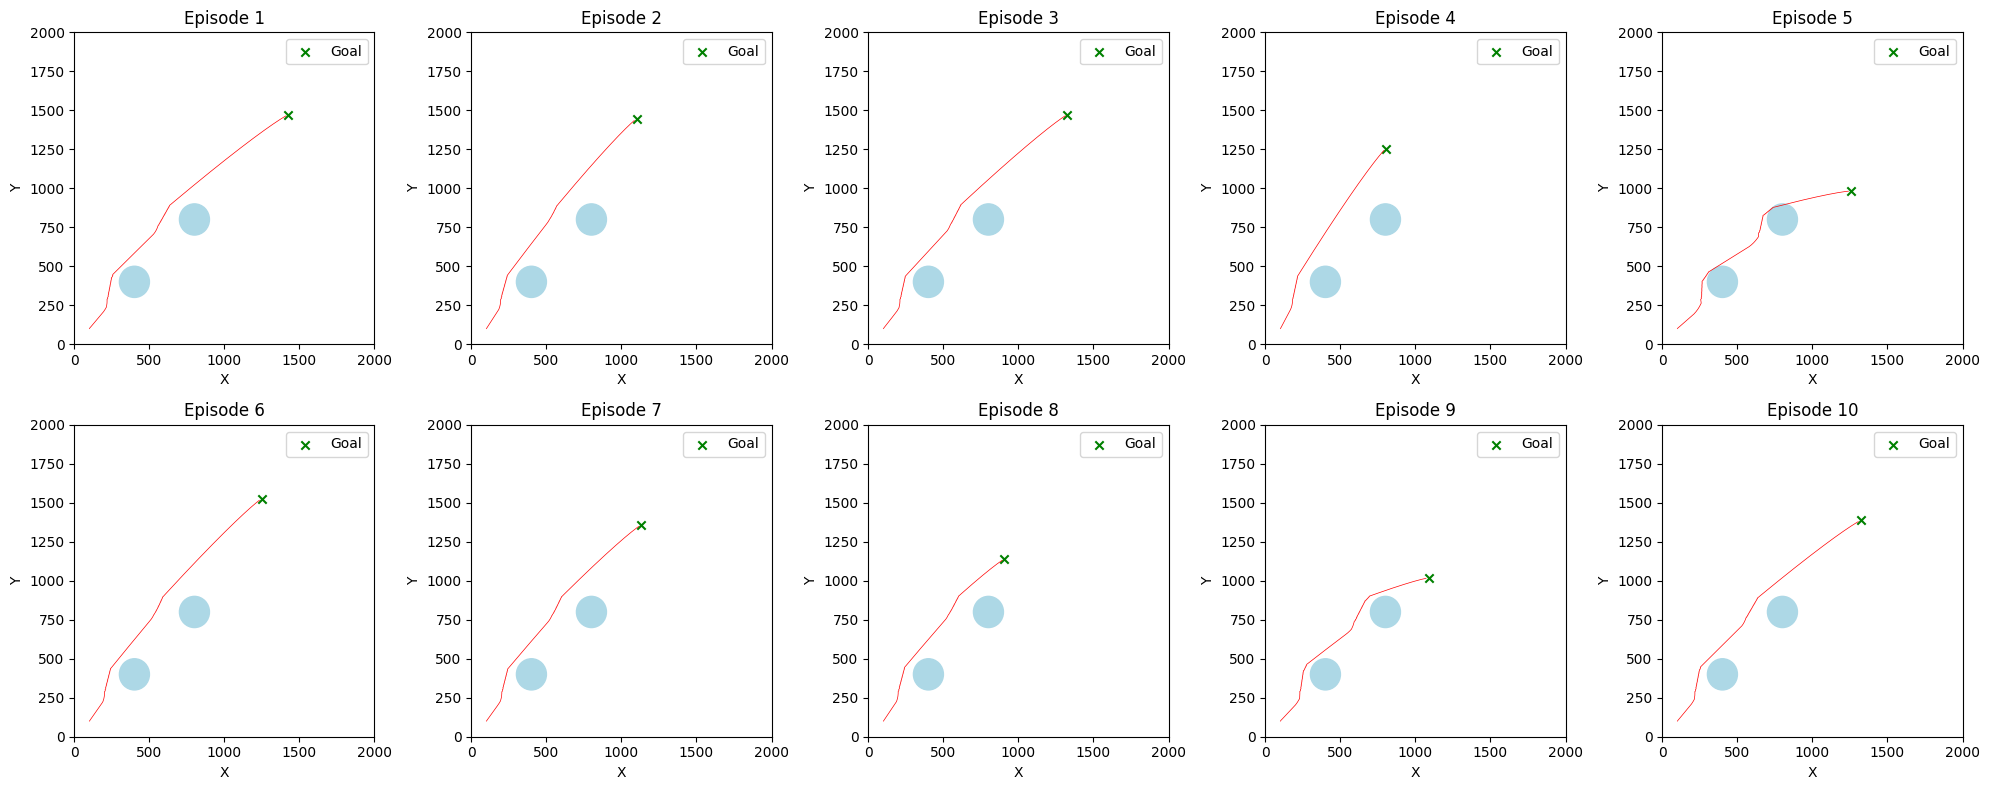

In [15]:
import matplotlib.pyplot as plt

# 创建一个包含10个子图的窗口
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.ravel()  # 将二维数组展平，方便通过索引访问每个子图

env = env_test1.DroneEnv()
for i in range(10):
    # 重置环境
    state, info = env.reset()
    trajectory_x = [env.xy_p[0]]  # 存储无人机路径的x坐标
    trajectory_y = [env.xy_p[1]]  # 存储无人机路径的y坐标
    trajectory_ex = [env.xy_e[0]]  # 存储无人机路径的x坐标
    trajectory_ey = [env.xy_e[1]]  # 存储无人机路径的y坐标
    
    # 在第i个子图中绘制环境和障碍物
    axs[i].scatter(env.xy_e[0], env.xy_e[1], marker='x', color='green', label='Goal')
    for k in env.obstacles:
        obstacle_circle = plt.Circle(k, env.r_obstacles, color='lightblue', fill=True)
        axs[i].add_patch(obstacle_circle)
    axs[i].set_xlim(env.space1.low[0], env.space1.high[0])
    axs[i].set_ylim(env.space1.low[1], env.space1.high[1])
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].legend()
    axs[i].set_title(f'Episode {i+1}')

    # 通过预训练模型控制无人机执行任务并绘制路径
    model = PPO.load("last_model") 
    done = False
    total_reward = 0
    count = 0
    while not done:
        count += 1
        action, _states = model.predict(state, deterministic=True)
        next_state, reward, done, t, info = env.step(action)
        #if reward < -10:
            #print(state, action, reward)
        if count > 500:
            done = True
        total_reward += reward
        state = next_state
        trajectory_x.append(env.xy_p[0])  # 更新无人机路径的x坐标
        trajectory_y.append(env.xy_p[1])  # 更新无人机路径的y坐标
        trajectory_ex.append(env.xy_e[0])  # 更新无人机路径的x坐标
        trajectory_ey.append(env.xy_e[1])  # 更新无人机路径的y坐标

    # 绘制无人机路径
    axs[i].plot(trajectory_x, trajectory_y, color='red', linewidth=0.5)
    axs[i].plot(trajectory_ex, trajectory_ey, color='red', linewidth=0.5)

    # 打印每个episode的总奖励
    print(f'Episode {i+1} total reward:', total_reward)

# 显示子图窗口
plt.tight_layout()
plt.show()
